# Classification of Pneumonia Chest X-rays using CNN

In [1]:
# Import the libraries

import os
from glob import glob
import random
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline

# Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

Using TensorFlow backend.


## Load and explore the images

The data is stored in the Xray folder in 3 sub-folders - train, val and test. Each of them has a subfolder each for NORMAL and PNEUMONIA. The path to these folders are stored in variables and used to load the data.

In [2]:
print(os.listdir("Xray"))

['.ipynb_checkpoints', 'val', 'train', 'test']


In [3]:
# path to the folder

train_folder = "Xray/train"
val_folder = "Xray/val"
test_folder = "Xray/test"

In [4]:
# import the Normal and Pneumonia images of training set

train_data_N = glob(train_folder+"/NORMAL/*.jpeg")
train_data_P = glob(train_folder+"/PNEUMONIA/*.jpeg")

In [5]:
# load the first image of each type.

img_normal = load_img(train_data_N[0])
img_sick = load_img(train_data_P[0])

NORMAL


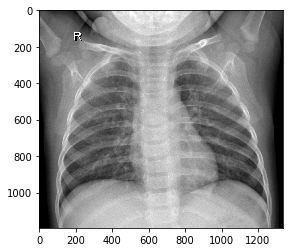

In [6]:
print('NORMAL')
plt.imshow(img_normal)
plt.show()

In [7]:
# print the mode, size of the image

print(type(img_normal))
print(img_normal.format)
print(img_normal.mode)
print(img_normal.size)

<class 'PIL.Image.Image'>
None
RGB
(1338, 1194)


PNEUMONIA


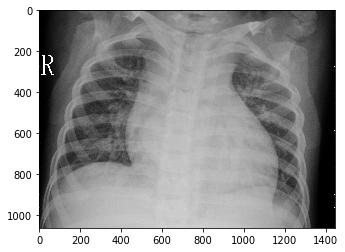

In [8]:
print('PNEUMONIA')
plt.imshow(img_sick)
plt.show()

In [9]:
# print the mode, size of the image

print(type(img_sick))
print(img_sick.format)
print(img_sick.mode)
print(img_sick.size)

<class 'PIL.Image.Image'>
None
RGB
(1448, 1064)


The size of the images are different in the 2 images and they are in RGB mode i.e., 3 channels.

In [10]:
# print the number of images in each class of the training set

print('Number of Normal xrays in training set: ' + str(len(train_data_N)))
print('Number of Pneumonia xrays in training set: ' + str(len(train_data_P)))
print('Total Number of xrays in training set: ' + str(len(train_data_N +train_data_P)))

Number of Normal xrays in training set: 1341
Number of Pneumonia xrays in training set: 3875
Total Number of xrays in training set: 5216


Text(0, 0.5, 'Count')

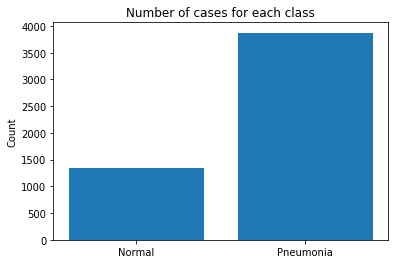

In [11]:
# Plot the number of images in each class in the training set

classes = ['Normal', 'Pneumonia']
counts = [len(train_data_N),len(train_data_P)]
plt.bar(classes, counts)
plt.title('Number of cases for each class')
plt.ylabel('Count')

In [12]:
# import the validation data

val_data_N = glob(val_folder+"/NORMAL/*.jpeg")
val_data_P = glob(val_folder+"/PNEUMONIA/*.jpeg")

In [13]:
# print the number of images in the validation data

print('Number of Normal xrays in validation set: ' + str(len(val_data_N)))
print('Number of Pneumonia xrays in validation set: ' + str(len(val_data_P)))
print('Total Number of xrays in validation set: ' + str(len(val_data_N+val_data_P)))

Number of Normal xrays in validation set: 8
Number of Pneumonia xrays in validation set: 8
Total Number of xrays in validation set: 16


In [14]:
# import the test data

test_data_N = glob(test_folder+"/NORMAL/*.jpeg")
test_data_P = glob(test_folder+"/PNEUMONIA/*.jpeg")

In [15]:
# print the number of images in the test data

print('Number of Normal xrays in test set: ' + str(len(test_data_N)))
print('Number of Pneumonia xrays in test set: ' + str(len(test_data_P)))
print('Total Number of xrays in test set: ' + str(len(test_data_N+test_data_P)))

Number of Normal xrays in test set: 234
Number of Pneumonia xrays in test set: 390
Total Number of xrays in test set: 624


The following function checks the minimum and maximum pixel sizes of all the images to see the range in the difference.

In [16]:
def find_pixel_size(list_data):
    "Finds the min and max of the sizes of each image in a list"
    
    pixels = [(np.asarray(plt.imread(i)).shape) for i in list_data]
    return ("Min: " + str(min(pixels)), "Max: " + str(max(pixels)))

In [17]:
print('Min and Max pixel sizes in the Normal training set')
find_pixel_size(train_data_N)

Min and Max pixel sizes in the Normal training set


('Min: (672, 912)', 'Max: (2663, 2373)')

In [18]:
print('Min and Max pixel sizes in the Pneumonia training set')
find_pixel_size(train_data_P)

Min and Max pixel sizes in the Pneumonia training set


('Min: (127, 384, 3)', 'Max: (2304, 2160)')

In [19]:
print('Min and Max pixel sizes in the Normal validation set')
find_pixel_size(val_data_N)

Min and Max pixel sizes in the Normal validation set


('Min: (928, 1288)', 'Max: (1416, 1776)')

In [20]:
print('Min and Max pixel sizes in the Pneumonia validation set')
find_pixel_size(val_data_P)

Min and Max pixel sizes in the Pneumonia validation set


('Min: (592, 968)', 'Max: (1128, 1664)')

In [21]:
print('Min and Max pixel sizes in the Normal test set')
find_pixel_size(test_data_N)

Min and Max pixel sizes in the Normal test set


('Min: (496, 984)', 'Max: (2713, 2517)')

In [22]:
print('Min and Max pixel sizes in the Pneumonia test set')
find_pixel_size(test_data_P)

Min and Max pixel sizes in the Pneumonia test set


('Min: (344, 888)', 'Max: (1456, 2000)')


From the above data analyses, we observe the following:

1) The pixel sizes of the images are different. On analysing the other files, the pixel sizes are all different. They need to be the same if we are using a fully connected layer in the neural network model. 

2) We also see that this is an imbalanced data set - the number of pneumonia xrays is way more than the normal xrays. We can use SMOTE to balance the data set - an oversampling technique that generates synthetic samples from the minority class. This means that the images have to be resized and converted to an array before oversampling as SMOTE takes the images represented as an array.  

3) All the images are in RGB mode.

## Data Wrangling and Preprocessing - Resizing, SMOTE

Create directories in the current folder to hold the resized images for visualisations. 

In [23]:
# Check if the directory exists and if not, create it.

p = os.getcwd()

dirs = ['trainN', 'trainP', 'valN', 'valP', 'testN', 'testP']
for i in dirs:
    if not os.path.exists(p+'/'+i):
        os.mkdir(i)
    else:
        print('Directory exists')

The images were resized to 128,128 pixel size. The following function loads the image from the list, resizes it and writes it to another folder in the current directory.

In [24]:
def resize_image(l,folder):
    "resize images in a list and return the new image in another folder"
    count = 1
    for name in l:
        image = cv2.imread(name)
        image = cv2.resize(image, (128, 128))
        cv2.imwrite(folder+'/resized_' +str(count) +'.jpeg', image)
        count += 1
    return

The resized train data - both Normal and Pneumonia - are taken from their individual folders, imported into a list format and then joined to get a single train set. The images in this set are then converted into a numpy array and then stored in trainx. The labels for this training set is made by creating a y_train, by appending the values for each Normal file as 0 and Pneumonia as 1.

In [25]:
# resize the images in normal training set

resize_image(train_data_N, 'trainN')

In [26]:
# resize images in Pneumonia training set

resize_image(train_data_P, 'trainP')

In [27]:
# Import the resized images

trainN = glob('trainN/*.jpeg')
trainP = glob('trainP/*.jpeg')

In [28]:
# Join the Normal and Pneumonia sets into a single list

train = trainN + trainP

In [29]:
# Each image in the list is converted to an array and stored in trainx

trainx = []
for i in train:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    trainx.append(img_array)

In [30]:
# The labels for the train set is made by appending 0 for a normal image and 1 for pneumonia image

y_train = []

for i in trainN:
    y_train.append(0)
for i in trainP:
    y_train.append(1)

In [31]:
# Convert the trainx into an array

trainx = np.array(trainx)
trainx.shape

(5216, 128, 128, 3)

In [32]:
# The shape of the trainx is (n_samples, width, height, channels). For SMOTE, the last 3 are combined to be the 
# features and multiplied to give the shape as a 2D flat shape.

s = trainx.shape[1]*trainx.shape[2]*trainx.shape[3]
X_trainFlat = trainx.reshape(trainx.shape[0], s)

In [33]:
# y_train is also converted to array

Y_train = np.array(y_train)

In [34]:
# Initiate the SMOTE

sm = SMOTE(random_state=42)

In [35]:
# Selected a few xrays with less of Normal and more of Pneumonia

Y_train[1335:1350]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
# Selected the images in the the same region, with 6 Normal and 9 Pneumonia

len(X_trainFlat[1335:1350])

15

In [37]:
# SMOTE this selection to see the image

tx_s, ty_s = sm.fit_resample(X_trainFlat[1335:1350],Y_train[1335:1350])

In [38]:
# checked for the number of Normal - it has increased by 3

tx_s.shape

(18, 49152)

In [39]:
# converted the flat image to its channels

for i in range(len(tx_s)):
    height, width, channels = 128, 128, 3
    tx_f = tx_s.reshape(len(tx_s), height, width, channels)

In [40]:
# located the SMOTEd samples

ty_s

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(128, 128)


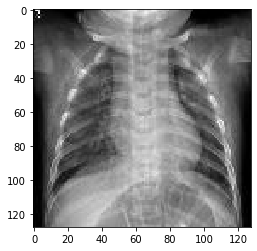

In [41]:
# Visualized one of the smoted samples by saving the array and loading the image again

a = tx_f[-2]
save_img('smoted.jpeg', a)
img = load_img('smoted.jpeg')

print(type(img))
print(img.format)
print(img.mode)
print(img.size)

plt.imshow(img)
plt.show()

In [42]:
# Now fit the SMOTE on the entire flat training set and the Y_train.

trainX_smote, trainY_smote = sm.fit_resample(X_trainFlat, Y_train)

In [43]:
# Check the number of Normal cases in the SMOTEd data - it has gone up from 1341 to match the no. of Pneumonia cases
# which is 3875

(trainY_smote == 0).sum()

3875

In [44]:
trainX_smote.shape

(7750, 49152)

Text(0, 0.5, 'Count')

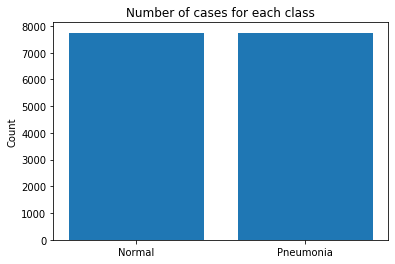

In [45]:
# Plotting the distribution of the classes in the training set.

classes = ['Normal', 'Pneumonia']
counts = [len(trainX_smote),len(trainY_smote)]
plt.bar(classes, counts)
plt.title('Number of cases for each class')
plt.ylabel('Count')

In [46]:
# Convert the flattened shape of the training set into the tuple with 4 values.

for i in range(len(trainX_smote)):
    height, width, channels = 128, 128, 3
    X_train_final = trainX_smote.reshape(len(trainX_smote), height, width, channels)

In [47]:
X_train_final.shape

(7750, 128, 128, 3)

The validation set and the test set are also resized and converted into an array with their respective labels. 

In [48]:
# convert the smoted Y labels to an array

y_train_final = np.array(trainY_smote)

In [49]:
# resize the normal validation data

resize_image(val_data_N,'valN')

In [50]:
# resize the pneumonia validatin data

resize_image(val_data_P,'valP')

In [51]:
# Load the resized images and join to a single val list

valN = glob('valN/*.jpeg')
valP = glob('valP/*.jpeg')
val = valN + valP

In [52]:
# Convert each image in the val set to an array

valx = []
for i in val:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    valx.append(img_array)

In [53]:
# Convert the list of arrays into an array

X_val_final = np.array(valx)
X_val_final.shape

(16, 128, 128, 3)

In [54]:
# Create the labels for the val set 

y_val = []

for i in valN:
    y_val.append(0)
for i in valP:
    y_val.append(1)

In [55]:
# Convert the y labels into an array

Y_val = np.array(y_val)

In [56]:
# resize the normal test data

resize_image(test_data_N,'testN')

In [57]:
# resize the pneumonia test data
resize_image(test_data_P,'testP')

In [58]:
# Load and join the test sets into single test set

testN = glob('testN/*.jpeg')
testP = glob('testP/*.jpeg')
test = testN + testP

In [59]:
# convert each image in the test set to an array

testx = []
for i in test:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    testx.append(img_array)

In [60]:
# Convert the list into an array

X_test_final = np.array(testx)
X_test_final.shape

(624, 128, 128, 3)

In [61]:
# Create the labels for the test set

y_test = []

for i in testN:
    y_test.append(0)
for i in testP:
    y_test.append(1)

In [62]:
# Convert the labels into an array

Y_test = np.array(y_test)

## Model Architecture

### Model 1

I am using a Sequential CNN model for this problem. The different layers are, 2 Convolutional 2D layer with ReLU (Rectified Linear Unit) activation followed by a MaxPooling2D layer after each convolution, 1 Fully Connected layers and the output layer with Sigmoid activation. The model is compiled with the Adam optimizer, loss function is binary crossentropy and the metrics used to evaluate is Accuracy, Precision, Recall and AUC (Area Under Curve). As this is now a balanced data set, Accuracy is acceptable. But, measuring the Precision, Recall and AUC gives us an idea of what SMOTE does to the data and these metrics.

In [63]:
# Optimizer

optimizer = optimizers.Adam(lr = 0.001)

In [64]:
# metrics

metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

In [65]:
# CNN model

cnn1 = Sequential()

# 1st Convolution
cnn1.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn1.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn1.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn1.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn1.add(Flatten())

# Fully Connected Layers
cnn1.add(Dense(activation = 'relu', units = 128))
cnn1.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)

In [66]:
cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3686528   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

#### Data Augmentation, Data Generators and Callbacks

The function ImageDataGenerator augments the image by iterating through image as your CNN is getting ready to process that image. Here, I am rescaling and doing a horizontal_flip to the image. This allows for the model to generalise. The test set is only rescaled. 

In [67]:
# Initiate the ImageDataGenerators with the rescaling and flip for the train set and another one with just the 
# rescaling for the test set. This can also be used for the validation set.

train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [68]:
# Using the flow method of the ImageDataGenerator to load the images in an array. The test_datagen is used on the
# validation and test set data.

training_set = train_datagen.flow(X_train_final, y_train_final, batch_size=32)

validation_set = test_datagen.flow(X_val_final, Y_val, batch_size=16)

test_set = test_datagen.flow(X_test_final, Y_test)

The callbacks for this model will be 1) Early Stopping Monitor - stops training when a monitored quantity has stopped improving, 2) ReduceLROnPlateau - reduces the learning rate when the metric has stopped improving and 3) TensorBoard - a visualization tool provided with TensorFlow, writes a log, which allows visualizing dynamic graphs of the training and test metrics, as well as activation histograms for the different layers in the model.

In [69]:
# Load the Tensorboard notebook extension

%load_ext tensorboard

In [70]:
# Clear any logs from previous runs

!rm -rf ./logs/

In [71]:
# Define the callbacks - reduce_lr, which reduces the learning rate by a factor of 0.2 if there is no improvement,
# early_stopping_monitor, which stops the training if there is not improvement for more than 3 epochs and the 
# tensorboard, which logs all the visualizations, graphs, histograms of the training and validation.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 3, min_lr=0.00001)

early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience = 3)

# The logs are placed in a timestamped subdirectory to allow easy selection of different runs
logdir1 = 'logs/mod1/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard1 = tf.keras.callbacks.TensorBoard(logdir1, write_graph=True, histogram_freq=1)

#### Training the Network

In [72]:
# Train the model on the data generated batch by batch by the ImageDataGenerator

cnn1.fit(training_set, 
        steps_per_epoch=len(X_train_final) // 32, 
        epochs=20,
        validation_data = validation_set,
        callbacks = [reduce_lr, early_stopping_monitor, tensorboard1])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 242 steps, validate for 1 steps
Epoch 1/20
242/242 [==============================] - 219s 906ms/step - loss: 0.2719 - accuracy: 0.8804 - precision: 0.8949 - recall: 0.8622 - auc: 0.9560 - val_loss: 0.1771 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/20
242/242 [==============================] - 225s 932ms/step - loss: 0.1076 - accuracy: 0.9613 - precision: 0.9650 - recall: 0.9573 - auc: 0.9918 - val_loss: 0.1137 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/20
242/242 [==============================] - 225s 928ms/step - loss: 0.0899 - accuracy: 0.9658 - precision: 0.9687 - recall: 0.9627 - auc: 0.9941 - val_loss: 0.2724 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
242/242 [==============================] - 227s 938ms/step - loss: 0.0691 - accuracy: 0.9759 - precision: 0.9792 - re

In [139]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod1

#### Evaluate and predict on the test set

In [74]:
# Evaluate the test set

test_accu1 = cnn1.evaluate(test_set)

  ...
    to  
  ['...']
20/20 [==============================] - 3s 170ms/step - loss: 1.6309 - accuracy: 0.7356 - precision: 0.7049 - recall: 0.9923 - auc: 0.7827


In [75]:
# print the metrics for the test set

print(cnn1.metrics_names)
print(test_accu1)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[1.6308511316776275, 0.7355769, 0.704918, 0.99230766, 0.78268135]


In [76]:
print('The test accuracy is :',round(test_accu1[1]*100,2), '%')

The test accuracy is : 73.56 %


In [77]:
# calculated the F1 score from the precision and recall of the test run

p1 = test_accu1[2]
r1 = test_accu1[3]
fscore1 = 2 * ((p1*r1)/(p1+r1))

print('The F1 Score for test is: ',round(fscore1, 2))

The F1 Score for test is:  0.82


### Model 2

In this model, 2 Dropout layers were added - one after the last maxPooling and one before the output layer. Dropout layers randomly set a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. Here the fraction is 0.5

In [78]:
# CNN model 2- with dropout

cnn2 = Sequential()

# 1st Convolution
cnn2.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn2.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn2.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn2.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout layer
cnn2.add(Dropout(0.5))

# Flatten the layer
cnn2.add(Flatten())

# Fully Connected Layer
cnn2.add(Dense(activation = 'relu', units = 128))

# Dropout layer
cnn2.add(Dropout(0.5))

# Fully Connected Layer
cnn2.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn2.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)

In [79]:
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [80]:
# Define the tensorboard callback with a different file log

logdir2 = 'logs/mod2/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard2 = tf.keras.callbacks.TensorBoard(logdir2, write_graph=True, histogram_freq=1)

In [81]:
# Train the model on the data generated batch by batch by the ImageDataGenerator

cnn2.fit(training_set, 
        steps_per_epoch=len(X_train_final) // 32, 
        epochs=20,
        validation_data = validation_set,
        callbacks = [reduce_lr, early_stopping_monitor, tensorboard2])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 242 steps, validate for 1 steps
Epoch 1/20
242/242 [==============================] - 205s 849ms/step - loss: 0.2606 - accuracy: 0.8903 - precision: 0.9033 - recall: 0.8740 - auc: 0.9593 - val_loss: 0.4111 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 0.9375
Epoch 2/20
242/242 [==============================] - 223s 923ms/step - loss: 0.1196 - accuracy: 0.9562 - precision: 0.9595 - recall: 0.9526 - auc: 0.9906 - val_loss: 0.1223 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/20
242/242 [==============================] - 227s 940ms/step - loss: 0.1005 - accuracy: 0.9653 - precision: 0.9684 - recall: 0.9619 - auc: 0.9933 - val_loss: 0.1325 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
242/242 [==============================] - 229s 948ms/step - loss: 0.0868 - accuracy: 0.9711 - precision: 0.9747 - re

In [140]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod2

#### Evaluate and predict on test set

In [83]:
# Evaluate the test set

test_accu2 = cnn2.evaluate(test_set)

  ...
    to  
  ['...']
20/20 [==============================] - 3s 169ms/step - loss: 1.1421 - accuracy: 0.7532 - precision: 0.7201 - recall: 0.9897 - auc: 0.8453


In [84]:
# print the metrics for the test

print(cnn2.metrics_names)
print(test_accu2)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[1.142105546593666, 0.7532051, 0.7201493, 0.9897436, 0.8452772]


In [85]:
print('The testing accuracy is :',round(test_accu2[1]*100, 2), '%')

The testing accuracy is : 75.32 %


In [86]:
# calculate the f1 score for the test set

p2 = test_accu2[2]
r2 = test_accu2[3]
fscore2 = 2 * ((p2*r2)/(p2+r2))

print('The F1 Score for test is: ',round(fscore2, 2))

The F1 Score for test is:  0.83


### Model 3

In this model, the class imbalance in the data is not addressed with SMOTE. The images are augmented during the ImageDataGenerator and used for training. Data augmentation ensuresw that the network sees 'transformed' or 'new' images that it has never seen before at each and every epoch. Augmentation is achieved by changes in scale, shearing, zooming and flips. The metrics that will be more relevant in this case, will be F1 score with Precision and Recall and the AUC. Class weights are computed and used during training based on class distribution.

In [87]:
# Image augmentation is done by the ImageDataGenerator class

train_datagenA = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2, horizontal_flip = True)

test_datagenA = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [88]:
# Make a directory to store the augmented images to visualise them

os.makedirs('aug_images')

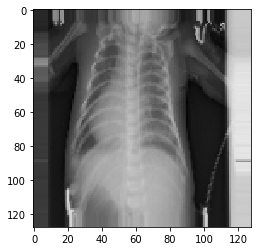

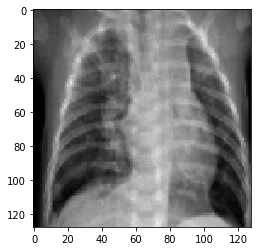

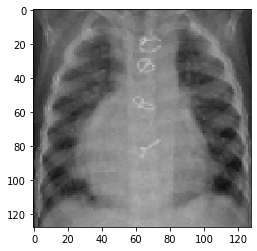

In [89]:
# Fit the generator to the training set without the SMOTE and store 3 pictures to the directory created above and 
# visualise the image

train_datagenA.fit(trainx)
for X_batch, y_batch in train_datagenA.flow(trainx, y_train, batch_size=3, save_to_dir='aug_images',
                                           save_prefix='aug', save_format='jpeg'):
    for i in range(0,3):
        plt.figure()
        plt.imshow(X_batch[i])
    break

In [90]:
# Use the generators initialised above to make the training, validation and test sets using the respective data

training_setA = train_datagenA.flow(trainx, y_train, batch_size=32)

validation_setA = test_datagenA.flow(X_val_final, Y_val, batch_size=16)

test_setA = test_datagenA.flow(X_test_final, Y_test)

In [91]:
# callbacks with monitor set as 'val_auc'

reduce_lr3 = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience = 3, min_lr=0.00001)

early_stopping_monitor3 = EarlyStopping(monitor = 'val_auc', patience = 3)

logdir3 = 'logs/mod3/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard3 = tf.keras.callbacks.TensorBoard(logdir3, write_graph=True, histogram_freq=1)

In [92]:
# class weights computed

classweight_s = compute_class_weight('balanced', np.unique(y_train), y_train)

In [93]:
# CNN model using the dropout layers from model #2

cnn3 = Sequential()

# 1st Convolution
cnn3.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn3.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn3.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn3.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout layer
cnn3.add(Dropout(0.5))

# Flatten the layer
cnn3.add(Flatten())

# Fully Connected Layer
cnn3.add(Dense(activation = 'relu', units = 128))

# Dropout layer
cnn3.add(Dropout(0.5))

# Fully Connected Layer
cnn3.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn3.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)

In [94]:
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [95]:
# Fit to the training set

cnn3.fit(training_setA, 
        steps_per_epoch=len(trainx) // 32, 
        epochs=20,
        class_weight = classweight_s,
        validation_data = validation_setA,
        callbacks = [reduce_lr3, early_stopping_monitor3, tensorboard3])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 1 steps
Epoch 1/20
163/163 [==============================] - 144s 886ms/step - loss: 0.4598 - accuracy: 0.8008 - precision: 0.7999 - recall: 0.9760 - auc: 0.7911 - val_loss: 0.4266 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 0.9688
Epoch 2/20
163/163 [==============================] - 148s 910ms/step - loss: 0.2933 - accuracy: 0.8813 - precision: 0.8992 - recall: 0.9463 - auc: 0.9330 - val_loss: 0.6171 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.9766
Epoch 3/20
163/163 [==============================] - 156s 957ms/step - loss: 0.2496 - accuracy: 0.9036 - precision: 0.9260 - recall: 0.9458 - auc: 0.9517 - val_loss: 0.7104 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.9844
Epoch 4/20
163/163 [==============================] - 159s 978ms/step - loss: 0.2362 - accuracy: 0.9022 - precision: 0.9274 - re

In [142]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod3

#### Evaluate and predict on test set

In [97]:
# Evaluate on test set

test_accu3 = cnn3.evaluate(test_setA)

  ...
    to  
  ['...']
20/20 [==============================] - 4s 175ms/step - loss: 0.3200 - accuracy: 0.8798 - precision: 0.8741 - recall: 0.9436 - auc: 0.9443


In [98]:
# print metrics

print(cnn3.metrics_names)
print(test_accu3)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[0.32001189440488814, 0.8798077, 0.87410927, 0.94358975, 0.94427466]


In [100]:
print('The test AUC is :',test_accu3[4])

The test AUC is : 0.94427466


In [248]:
# calculate the f1 score

p3 = test_accu3[2]
r3 = test_accu3[3]
fscore3 = 2 * ((p3*r3)/(p3+r3))
print('The F1 Score is :',fscore3)

The F1 Score is : 0.9075216054916382


### Model 4

Another model with an additional convoluted layer and a fully connected layer is added to the model used with the SMOTED data to see if there was a difference in accuracy or F1.

In [103]:
# Callback using tensorboard

logdir4 = 'logs/mod4/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard4 = tf.keras.callbacks.TensorBoard(logdir4, write_graph=True, histogram_freq=1)

In [104]:
cnn4 = Sequential()

# 1st Convolution
cnn4.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn4.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn4.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn4.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd Convolution
cnn4.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 3rd Pooling layer
cnn4.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout layer
cnn4.add(Dropout(0.5))

# Flatten the layer
cnn4.add(Flatten())

# Fully Connected Layer
cnn4.add(Dense(activation = 'relu', units = 128))

# Dropout layer
cnn4.add(Dropout(0.5))

# Fully Connected Layer
cnn4.add(Dense(activation = 'relu', units = 64))

# Fully Connected Layer
cnn4.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn4.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)

In [105]:
cnn4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)       

In [106]:
# fit the model

cnn4.fit(training_set, 
        steps_per_epoch=len(X_train_final) // 32, 
        epochs=20,
        validation_data = validation_set,
        callbacks = [reduce_lr, early_stopping_monitor, tensorboard4])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 242 steps, validate for 1 steps
Epoch 1/20
242/242 [==============================] - 217s 897ms/step - loss: 0.6615 - accuracy: 0.6126 - precision: 0.6251 - recall: 0.5619 - auc: 0.6618 - val_loss: 0.6156 - val_accuracy: 0.5625 - val_precision: 0.5455 - val_recall: 0.7500 - val_auc: 0.7578
Epoch 2/20
242/242 [==============================] - 228s 943ms/step - loss: 0.5211 - accuracy: 0.7696 - precision: 0.7835 - recall: 0.7445 - auc: 0.8501 - val_loss: 0.5953 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.8438
Epoch 3/20
242/242 [==============================] - 228s 944ms/step - loss: 0.3967 - accuracy: 0.8412 - precision: 0.8502 - recall: 0.8287 - auc: 0.9180 - val_loss: 0.5020 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - val_auc: 0.9062
Epoch 4/20
242/242 [==============================] - 234s 968ms/step - loss: 0.3176 - accuracy: 0.8818 - precision: 0.8919 - re

In [143]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod4

#### Evaluate and predict on test set

In [108]:
# evaluate on test set

test_accu4 = cnn4.evaluate(test_set)

  ...
    to  
  ['...']
20/20 [==============================] - 4s 187ms/step - loss: 0.5699 - accuracy: 0.7772 - precision: 0.7485 - recall: 0.9692 - auc: 0.9173


In [109]:
# Print metrics

print(cnn4.metrics_names)
print(test_accu4)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[0.5699277311563492, 0.7772436, 0.74851483, 0.9692308, 0.9173405]


In [110]:
print('The testing accuracy is :',round(test_accu4[1]*100, 2), '%')

The testing accuracy is : 77.72 %


In [111]:
# Calculate the F1 score

p4 = test_accu4[2]
r4 = test_accu4[3]
fscore4 = 2 * ((p4*r4)/(p4+r4))

print('The F1 Score for test is: ',round(fscore4, 2))

The F1 Score for test is:  0.84


### Model 5 - Transfer learning using InceptionV3

We can try Transfer learning as done in one of the research publication. Here, we take pre-trained weights of an already trained model and use them to predict new classes. There are several models - we will use the InceptionV3 as mentioned in the paper. Since, the paper uses 'Softmax' activation, we tried with both 'Softmax' and 'Sigmoid' activations. The optimizers used were 'RMSprop' and 'Adam'. For Softmax, we need 2 output neurons and hence the labels need to be represented in a 2D array. 

In [112]:
# Converting the SMOTEd labels to 2D array for train, val and test sets

y_train_f2d = []

for i in y_train_final:
    if i == 0:
        y_train_f2d.append([i, i+1])
    else:
        y_train_f2d.append([i, i-1])
        

In [113]:
y_val_f2d = []

for i in Y_val:
    if i == 0:
        y_val_f2d.append([i, i+1])
    else:
        y_val_f2d.append([i, i-1])

In [114]:
y_test_f2d = []

for i in Y_test:
    if i == 0:
        y_test_f2d.append([i, i+1])
    else:
        y_test_f2d.append([i, i-1])

In [115]:
# The generators were used to get images from the 2D labels and their predictors.

training_set5 = train_datagen.flow(X_train_final, y_train_f2d, batch_size=32)

validation_set5 = test_datagen.flow(X_val_final, y_val_f2d, batch_size=16)

test_set5 = test_datagen.flow(X_test_final, y_test_f2d)

In [144]:
# defined the parameters needed for using the Inception V3 model. 2 types of optimizers and activations were defined.

pretrained_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(128, 128, 3))

# RMSprop optimizer
optimizer_rms = keras.optimizers.RMSprop(lr=0.0001)
# Adam optimizer
optimizer_adam = optimizer

# Defined the input and output 
base_model = pretrained_model 
x = base_model.output
x = Flatten()(x)

# Softmax activation
predictions_SM = Dense(2, activation='softmax')(x)
# Sigmoid activation
predictions_Sig = Dense(1, activation='sigmoid')(x)

In [145]:
# Model 1 - softmax and RMSprop   
model1 = Model(inputs=base_model.input, outputs=predictions_SM)
       
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
model1.compile(loss='categorical_crossentropy',optimizer=optimizer_rms, metrics=metrics)

model1.summary()  

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 63, 63, 32)   96          conv2d_385[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 63, 63, 32)   0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [149]:
logdirt = 'logs/PT1/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboardt = tf.keras.callbacks.TensorBoard(logdirt, write_graph=True, histogram_freq=1)

In [150]:
# Fit model

history = model1.fit(training_set5, epochs=20, 
                    validation_data=validation_set5, verbose=1,
                    callbacks = [reduce_lr, early_stopping_monitor, tensorboardt])  

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 243 steps, validate for 1 steps
Epoch 1/20
243/243 [==============================] - 271s 1s/step - loss: 0.5107 - accuracy: 0.7583 - precision: 0.7583 - recall: 0.7583 - auc: 0.8321 - val_loss: 1.4583 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875 - val_auc: 0.6250
Epoch 2/20
243/243 [==============================] - 293s 1s/step - loss: 0.3639 - accuracy: 0.8483 - precision: 0.8483 - recall: 0.8483 - auc: 0.9211 - val_loss: 1.3149 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875 - val_auc: 0.7422
Epoch 3/20
243/243 [==============================] - 296s 1s/step - loss: 0.3216 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8692 - auc: 0.9387 - val_loss: 1.3298 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875 - val_auc: 0.7656
Epoch 4/20
243/243 [==============================] - 290s 1s/step - loss: 0.3009 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839

In [151]:
 # Evaluate model
    
test_accuT1 = model1.evaluate(test_set5, verbose=0)

  ...
    to  
  ['...']


In [152]:
# print metrics

print(model1.metrics_names)
print(test_accuT1)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[1.0447927877306937, 0.7291667, 0.7291667, 0.7291667, 0.80006474]


In [153]:
print('\nKeras CNN - accuracy:', test_accuT1[1], '\n')


Keras CNN - accuracy: 0.7291667 



In [154]:
# Compute the F1 Score
pt1 = test_accuT1[2]
rt1 = test_accuT1[3]
fscoret1 = 2 * ((pt1*rt1)/(pt1+rt1))

print('The F1 Score for test is: ',round(fscoret1, 2))

The F1 Score for test is:  0.73


In [155]:
%tensorboard --logdir logs/PT1

In [156]:
# Model 2 - softmax and Adam  
model2 = Model(inputs=base_model.input, outputs=predictions_SM)

          
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
model2.compile(loss='categorical_crossentropy',optimizer=optimizer_adam, metrics=metrics)

model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 63, 63, 32)   96          conv2d_385[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 63, 63, 32)   0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
activation_454 (Activation)     (None, 2, 2, 384)    0           batch_normalization_454[0][0]    
__________________________________________________________________________________________________
activation_455 (Activation)     (None, 2, 2, 384)    0           batch_normalization_455[0][0]    
__________________________________________________________________________________________________
activation_458 (Activation)     (None, 2, 2, 384)    0           batch_normalization_458[0][0]    
__________________________________________________________________________________________________
activation_459 (Activation)     (None, 2, 2, 384)    0           batch_normalization_459[0][0]    
__________________________________________________________________________________________________
batch_normalization_460 (BatchN (None, 2, 2, 192)    576         conv2d_469[0][0]                 
__________

In [157]:
logdirt2 = 'logs/PT2/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboardt2 = tf.keras.callbacks.TensorBoard(logdirt2, write_graph=True, histogram_freq=1)

In [158]:
# Fit model

history2 = model2.fit(training_set5, epochs=20,
                    validation_data=validation_set5, verbose=1,
                    callbacks = [reduce_lr, early_stopping_monitor, tensorboardt2])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 243 steps, validate for 1 steps
Epoch 1/20
243/243 [==============================] - 300s 1s/step - loss: 0.2544 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9608 - val_loss: 1.1643 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250 - val_auc: 0.7578
Epoch 2/20
243/243 [==============================] - 290s 1s/step - loss: 0.2447 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9638 - val_loss: 1.1903 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875 - val_auc: 0.7656
Epoch 3/20
243/243 [==============================] - 296s 1s/step - loss: 0.2527 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9618 - val_loss: 1.1522 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250 - val_auc: 0.7227
Epoch 4/20
243/243 [==============================] - 296s 1s/step - loss: 0.2506 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040

In [182]:
%tensorboard --logdir logs/PT2

In [159]:
# Evaluate model
    
test_accuT2 = model2.evaluate(test_set5, verbose=0)

  ...
    to  
  ['...']


In [160]:
# print metrics

print(model2.metrics_names)
print(test_accuT2)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[1.0597724452614785, 0.7323718, 0.7323718, 0.7323718, 0.7994252]


In [161]:
print('\nKeras CNN - accuracy:', test_accuT2[1], '\n')


Keras CNN - accuracy: 0.7323718 



In [162]:
# Compute F1 Score

pt2 = test_accuT2[2]
rt2 = test_accuT2[3]
fscoret2 = 2 * ((pt2*rt2)/(pt2+rt2))

print('The F1 Score for test is: ',round(fscoret2, 2))

The F1 Score for test is:  0.73


In [163]:
# Model 3 - sigmoid and RMSprop   
model3 = Model(inputs=base_model.input, outputs=predictions_Sig)

          
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
model3.compile(loss='categorical_crossentropy',optimizer=optimizer_rms, metrics=metrics)

model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 63, 63, 32)   96          conv2d_385[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 63, 63, 32)   0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

conv2d_466 (Conv2D)             (None, 2, 2, 384)    1548288     activation_456[0][0]             
__________________________________________________________________________________________________
batch_normalization_453 (BatchN (None, 2, 2, 384)    1152        conv2d_462[0][0]                 
__________________________________________________________________________________________________
batch_normalization_457 (BatchN (None, 2, 2, 384)    1152        conv2d_466[0][0]                 
__________________________________________________________________________________________________
activation_453 (Activation)     (None, 2, 2, 384)    0           batch_normalization_453[0][0]    
__________________________________________________________________________________________________
activation_457 (Activation)     (None, 2, 2, 384)    0           batch_normalization_457[0][0]    
__________________________________________________________________________________________________
conv2d_463

In [174]:
logdirt3 = 'logs/PT3/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboardt3 = tf.keras.callbacks.TensorBoard(logdirt3, write_graph=True, histogram_freq=1)

In [175]:
# Fit model

history3 = model3.fit(training_set, epochs=20,
                    validation_data=validation_set, verbose=1,
                    callbacks = [reduce_lr, early_stopping_monitor, tensorboardt3])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 243 steps, validate for 1 steps
Epoch 1/20
243/243 [==============================] - 266s 1s/step - loss: 5.9737e-08 - accuracy: 0.4924 - precision: 0.4899 - recall: 0.3706 - auc: 0.4887 - val_loss: 5.9605e-08 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.4688
Epoch 2/20
243/243 [==============================] - 278s 1s/step - loss: 5.9737e-08 - accuracy: 0.4883 - precision: 0.4844 - recall: 0.3654 - auc: 0.4906 - val_loss: 5.9605e-08 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.4688
Epoch 3/20
243/243 [==============================] - 278s 1s/step - loss: 5.9737e-08 - accuracy: 0.5023 - precision: 0.5031 - recall: 0.3796 - auc: 0.4958 - val_loss: 5.9605e-08 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.4688
Epoch 4/20
243/243 [==============================] - 280s 1s/step - loss: 5.9737e-08 - accuracy: 0.4912 - precis

In [180]:
%tensorboard --logdir logs/PT3

In [176]:
# Evaluate model
    
test_accuT3 = model3.evaluate(test_set, verbose=0)

  ...
    to  
  ['...']


In [177]:
# print metrics

print(model3.metrics_names)
print(test_accuT3)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[7.450580596923828e-08, 0.49679488, 0.74050635, 0.3, 0.6030189]


In [178]:
print('\nKeras CNN - accuracy:', test_accuT3[1], '\n')


Keras CNN - accuracy: 0.49679488 



In [179]:
# Compute f1 Score

pt3 = test_accuT3[2]
rt3 = test_accuT3[3]
fscoret3 = 2 * ((pt3*rt3)/(pt3+rt3))

print('The F1 Score for test is: ',round(fscoret3, 2))

The F1 Score for test is:  0.43


In [166]:
# Model 4 - sigmoid and Adam   
model4 = Model(inputs=base_model.input, outputs=predictions_Sig)

          
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
model4.compile(loss='categorical_crossentropy',optimizer=optimizer_adam, metrics=metrics)

model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 63, 63, 32)   96          conv2d_385[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 63, 63, 32)   0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

batch_normalization_465 (BatchN (None, 2, 2, 448)    1344        conv2d_474[0][0]                 
__________________________________________________________________________________________________
activation_465 (Activation)     (None, 2, 2, 448)    0           batch_normalization_465[0][0]    
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 2, 2, 384)    786432      mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_475 (Conv2D)             (None, 2, 2, 384)    1548288     activation_465[0][0]             
__________________________________________________________________________________________________
batch_normalization_462 (BatchN (None, 2, 2, 384)    1152        conv2d_471[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [167]:
logdirt4 = 'logs/PT4/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboardt4 = tf.keras.callbacks.TensorBoard(logdirt4, write_graph=True, histogram_freq=1)

In [168]:
# Fit model

history4 = model4.fit(training_set, epochs=20,
                    validation_data=validation_set, verbose=1,
                    callbacks = [reduce_lr, early_stopping_monitor, tensorboardt4])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 243 steps, validate for 1 steps
Epoch 1/20
243/243 [==============================] - 285s 1s/step - loss: 5.9737e-08 - accuracy: 0.4947 - precision: 0.4930 - recall: 0.3750 - auc: 0.4799 - val_loss: 5.9605e-08 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.4688
Epoch 2/20
243/243 [==============================] - 284s 1s/step - loss: 5.9737e-08 - accuracy: 0.4921 - precision: 0.4894 - recall: 0.3646 - auc: 0.4900 - val_loss: 5.9605e-08 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.4688
Epoch 3/20
243/243 [==============================] - 281s 1s/step - loss: 5.9737e-08 - accuracy: 0.4950 - precision: 0.4933 - recall: 0.3724 - auc: 0.4928 - val_loss: 5.9605e-08 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.4688
Epoch 4/20
243/243 [==============================] - 283s 1s/step - loss: 5.9737e-08 - accuracy: 0.5010 - precis

In [181]:
%tensorboard --logdir logs/PT4

In [169]:
# Evaluate model
    
test_accuT4 = model4.evaluate(test_set, verbose=0)

  ...
    to  
  ['...']


In [170]:
# print metrics

print(model4.metrics_names)
print(test_accuT4)

['loss', 'accuracy', 'precision', 'recall', 'auc']
[7.450580596923828e-08, 0.49679488, 0.74050635, 0.3, 0.6030189]


In [171]:
print('\nKeras CNN - accuracy:', test_accuT4[1], '\n')


Keras CNN - accuracy: 0.49679488 



In [172]:
# compute f1 score

pt4 = test_accuT4[2]
rt4 = test_accuT4[3]
fscoret4 = 2 * ((pt4*rt4)/(pt4+rt4))

print('The F1 Score for test is: ',round(fscoret4, 2))

The F1 Score for test is:  0.43


### Results

In [196]:
# Accuracy

accuracy = [test_accu1[1], test_accu2[1], test_accu4[1], test_accu3[1], test_accuT1[1], test_accuT2[1], test_accuT3[1], test_accuT4[1]]

In [197]:
# F1 Score

f1score = [fscore1, fscore2, fscore4, fscore3, fscoret1, fscoret2, fscoret3, fscoret4]

In [198]:
# Precision

precision = [test_accu1[2], test_accu2[2], test_accu4[2], test_accu3[2], test_accuT1[2], test_accuT2[2], test_accuT3[2], test_accuT4[2]]

In [199]:
# Recall

recall = [test_accu1[3], test_accu2[3], test_accu4[3], test_accu3[3], test_accuT1[3], test_accuT2[3], test_accuT3[3], test_accuT4[3]]

In [200]:
# AUC

auc = [test_accu1[4], test_accu2[4], test_accu4[4], test_accu3[4], test_accuT1[4], test_accuT2[4], test_accuT3[4], test_accuT4[4]]

In [201]:
import seaborn as sns

Text(0.5, 1.0, 'Accuracy of different Models')

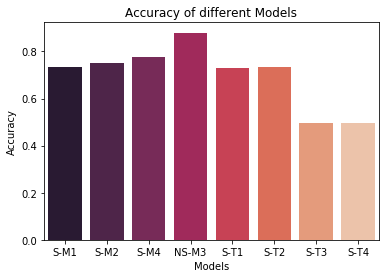

In [233]:
# Accuracy

x_a = np.array(accuracy)
y = ['S-M1', 'S-M2', 'S-M4', 'NS-M3', 'S-T1', 'S-T2', 'S-T3', 'S-T4']
sns.barplot(y, x_a, palette='rocket')

plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Accuracy of different Models')

Text(0.5, 1.0, 'F1 Score of different Models')

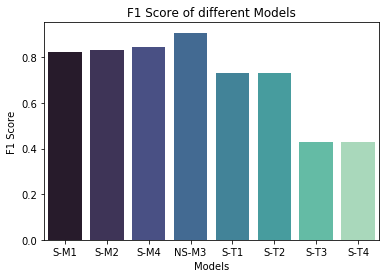

In [234]:
#F1 Score

x_f = np.array(f1score)
y = ['S-M1', 'S-M2', 'S-M4', 'NS-M3', 'S-T1', 'S-T2', 'S-T3', 'S-T4']
sns.barplot(y, x_f, palette='mako')

plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.title('F1 Score of different Models')

Text(0.5, 0.98, 'Precision-Recall of different Models')

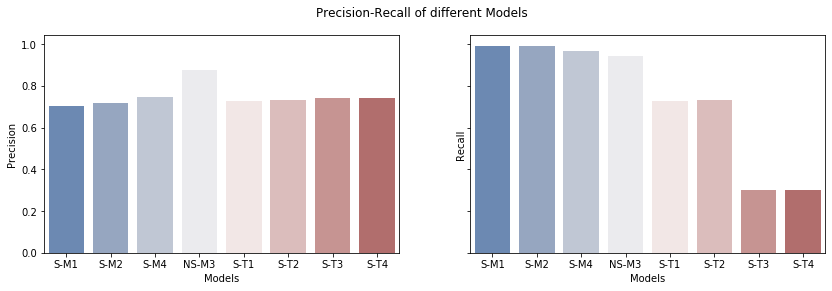

In [245]:
# Precision and Recall

f, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4), sharey=True)
x_p = np.array(precision)
x_r = np.array(recall)
y = ['S-M1', 'S-M2', 'S-M4', 'NS-M3', 'S-T1', 'S-T2', 'S-T3', 'S-T4']
sns.barplot(y, x_p, ax=ax1, palette='vlag')
ax1.set_ylabel('Precision')
ax1.set_xlabel('Models')
sns.barplot(y, x_r, ax=ax2, palette='vlag')
ax2.set_ylabel('Recall')
ax2.set_xlabel('Models')
f.suptitle('Precision-Recall of different Models')

Text(0.5, 1.0, 'AUC of different Models')

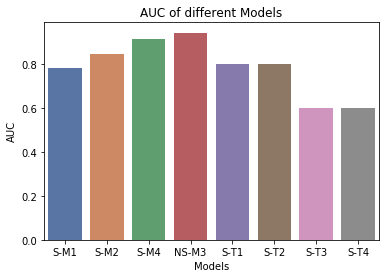

In [246]:
# AUC

x_u = np.array(auc)
y = ['S-M1', 'S-M2', 'S-M4', 'NS-M3', 'S-T1', 'S-T2', 'S-T3', 'S-T4']
sns.barplot(y, x_u, palette='deep')

plt.ylabel('AUC')
plt.xlabel('Models')
plt.title('AUC of different Models')

### Summary

The above figures summarise the results of this project. The first 3 models, S-M1, S-M2 and S-M4 are all variations of a convoluted neural network varying with the number of convolutions and dropout layers or fully connected layers. These 3 models used the SMOTEd balanced data set. The NS-M3 is the Non-SMOTEd data set using M2 architecture with class weights. The S-T1, S-T2, S-T3 and S-T4 are all transfer learning models with different output layers. T1 and T2 use Softmax activation with RMSprop and Adam optimizers respectively. T3 and T4 use Sigmoid activation with RMSprop and Adam optimizers.

There is a slight increase in accuracy as we go from the 1st to the 3rd model in the graph. But, the NS-M3 has the highest accuracy and F1 Score among all. Of the 4 pre-trained models, the ones that used softmax activation were the only one that showed some learning and performed reasonably well. The ones that used Sigmoid activation did not converge or did not learn anything.

In this dataset, though the data is imbalanced, the positive or the Pneumonia cases are the majority and the normal or the negative cases are the minority. So, there is a bias to selecting the positive cases. This is reflected in the high recall but precision is low as compared to recall. Precision is also the most in the non-SMOTEd data set. The F1 score is also high in this model. So, Data augmentation with class weights seems to have worked better than SMOTE. Using Data Augmentation to produce data and then use it might be a better approach for imbalanced image data sets.
